## Получение и предобработка данных

In [46]:
import pandas as pd
import numpy as np
import sqlalchemy
from clickhouse_driver import Client

### Подключаемся к Clickhouse для получения данных

In [47]:
client = Client('89.208.84.253',
                port= '59000',
                user='student',
                password='nUrHdn2N',
                secure=False,
                verify=True,
                database='data_analysis',
                compression=False)

In [74]:
query_views = """select *
from data_analysis.views
"""

query_orders = """select *
from data_analysis.orders
"""

result,columns = client.execute(query_views, with_column_types=True)
views = pd.DataFrame(result, columns = [tuple[0] for tuple in columns])

result,columns = client.execute(query_orders, with_column_types=True)
orders = pd.DataFrame(result, columns = [tuple[0] for tuple in columns])

In [75]:
views.head()

,idhash_view,view_dttm,tariff,idhash_order,idhash_client,client_bill_usd,latitude,longitude,del_latitude,del_longitude
0,944452746,2015-12-14 19:43:26,Эконом,0,3923985705,2.52,57.622251,39.883861,57.636150,39.844848
1,1124126659,2015-12-14 19:43:28,Комфорт,0,1613934680,0.00,55.884660,37.408535,0.000000,0.000000
2,4108744040,2015-12-14 19:43:28,Эконом,0,112675651,5.57,57.696041,39.793804,57.677161,39.900115
3,2884954660,2015-12-14 19:43:29,Эконом,0,1584742787,3.31,57.571621,39.856915,57.610347,39.831193
4,3769769055,2015-12-14 19:43:30,Эконом,0,2202904080,5.99,55.768278,37.556728,55.774841,37.709461


In [76]:
orders.head()

,idhash_order,idhash_view,order_dttm,da_dttm,rfc_dttm,cc_dttm,finish_dttm,cancel_dttm,status
0,3777115420,95199865,2015-12-06 00:00:09,2015-12-06 00:00:09,2015-12-06 00:03:31,2015-12-06 00:04:59,2015-12-06 00:10:06,NaT,CP
1,2983673012,3853062057,2015-12-06 00:00:11,2015-12-06 00:00:12,NaT,NaT,NaT,2015-12-06 00:01:26,CC
2,2177076394,147233410,2015-12-06 00:00:26,2015-12-06 00:00:37,2015-12-06 00:04:31,2015-12-06 00:07:06,2015-12-06 00:12:29,NaT,CP
3,1997846256,518227239,2015-12-06 00:00:32,2015-12-06 00:00:41,2015-12-06 00:04:04,2015-12-06 00:06:08,2015-12-06 00:17:11,NaT,CP
4,1893504594,3623774808,2015-12-06 00:01:07,2015-12-06 00:04:46,2015-12-06 00:11:35,2015-12-06 00:13:01,2015-12-06 00:29:43,NaT,CP


### RFM-сегментация

In [51]:
views['client_bill_rub'] =  views['client_bill_usd'] * 75

Для RFM-сегментации нам нужна информация о:
* дате последнего заказа
* частоте заказов
* сумме заказов

Заказ будем считать совершенным, если человека без происшествий довезли до пункта назначения, то есть если имеется дата завершения поездки колонки "finish_dttm" таблицы с заказами:

In [52]:
completed_orders = orders.dropna(subset = ['finish_dttm'])

Приджоиним информацию о сумме каждого заказа из views:

In [60]:
completed_orders = completed_orders.drop('idhash_view', axis = 1).join(views.set_index('idhash_order'), on='idhash_order', how = 'left')

Оставляем только нужные нам для сегментации колонки:

In [67]:
completed_orders = completed_orders.drop(['da_dttm', 'rfc_dttm', 'cc_dttm', 'cancel_dttm', 'status', 'idhash_view', 'client_bill_usd', 'latitude', 'longitude', 'del_latitude', 'del_longitude'], axis = 1)

In [77]:
completed_orders

,idhash_order,order_dttm,finish_dttm,view_dttm,tariff,idhash_client,client_bill_rub
0,3777115420,2015-12-06 00:00:09,2015-12-06 00:10:06,2015-12-06 00:00:06,Эконом,2.606231e+08,115.500
2,2177076394,2015-12-06 00:00:26,2015-12-06 00:12:29,2015-12-06 00:00:25,Эконом,1.419240e+09,141.000
3,1997846256,2015-12-06 00:00:32,2015-12-06 00:17:11,2015-12-06 00:00:26,Эконом,3.243818e+09,384.000
4,1893504594,2015-12-06 00:01:07,2015-12-06 00:29:43,2015-12-06 00:00:48,Комфорт+,2.978411e+09,529.500
9,1786344293,2015-12-06 00:02:09,2015-12-06 00:18:00,2015-12-06 00:02:02,Эконом,1.583693e+09,208.500
...,...,...,...,...,...,...,...
86115,1766787720,2015-12-19 23:58:05,2015-12-20 00:11:39,2015-12-19 23:57:56,Эконом,2.361156e+09,222.750
86116,906364318,2015-12-19 23:58:20,2015-12-20 00:08:35,2015-12-19 23:58:13,Эконом,4.145563e+09,198.750
86117,2921584586,2015-12-19 23:58:26,2015-12-20 00:19:02,2015-12-19 23:58:17,Комфорт,8.464269e+08,381.375
86119,1146229702,2015-12-19 23:58:59,2015-12-20 00:16:25,2015-12-19 23:58:54,Комфорт,8.030496e+08,540.000


#### Определим границы наших сегментов

##### recency

Сгруппируем по пользователем и:
* поставим в колонку recent - самый недавний заказ
* просуммируем все заказы
* посчитаем количество всех заказов

In [95]:
grouped = completed_orders.groupby('idhash_client').agg(
    {'client_bill_rub': ['mean', 'count'],
     'order_dttm': 'max'}
)
monetary = grouped[('client_bill_rub', 'mean')]
frequency = grouped[('client_bill_rub', 'count')]
recency = grouped[('order_dttm', 'max')]

На каждый признак построим гистограммы, посмотрим перцентили и решим, где прочертить границы нашей сегментации:

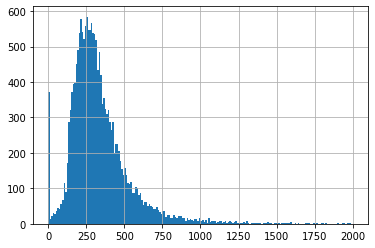

In [98]:
import matplotlib.pyplot as plt

monetary.hist(bins = 200, range = (0, 2000))
plt.show()


Большое скопление заказов с нулевой суммой выбросом не считаю, так как это люди, оплатившие поездку бонусами (я надеюсь), а значит это тоже наши клиенты, которые в данной поездке пошли нам в убыток.

Применим равномерное сегментирование по диапазонам значений:

In [138]:
range = monetary.quantile(0.97) - monetary.quantile(0.03)
step = range / 3

border_1 = monetary.quantile(0.03) + step
border_2 = border_1 + step

print('{} - {}   ~{}%'.format(monetary.min(), border_1, 58))
print('{} - {}   ~{}%'.format(border_1, border_2, 32))
print('{} - {}   ~{}%'.format(border_2, monetary.max(), 10))

0.0 - 321.0   ~58%
321.0 - 572.25   ~32%
572.25 - 23015.25   ~10%
